In [23]:
import numpy as np
import matplotlib.pyplot as plt

from stacked_mnist import StackedMNISTData, DataMode
from models.vae import VAE
from models.mnist_classifier import MNISTClassifier

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from utils import *

In [24]:
# Using the provided mnist dataset class
gen = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE, default_batch_size=9)

train_data = gen.get_full_data_set(training=True)
test_data = gen.get_full_data_set(training=False)

In [25]:
train_data[0].shape, test_data[0].shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

(60000, 28, 28, 3) (60000,)
(10000, 28, 28, 3) (10000,)
(28, 28, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

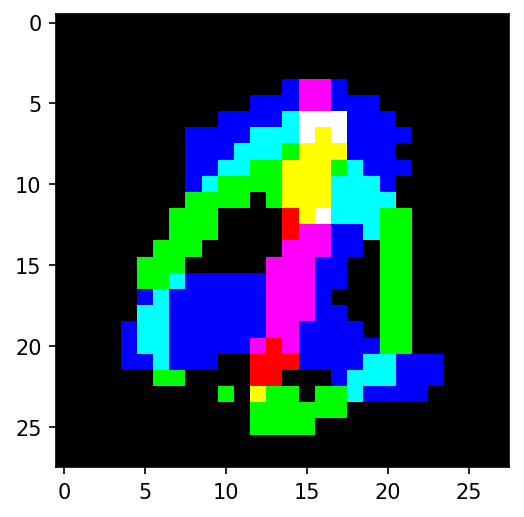

In [26]:
x_train, y_train = train_data
x_test, y_test = test_data
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Convert y_train and y_test into one-hot vectors
y_train = to_one_hot_rgb(y_train)
y_test = to_one_hot_rgb(y_test)

rand = np.random.randint(0, x_train.shape[0])
img = x_train[rand]
label = y_train[rand]
print(img.shape)

print(label)
print(label.argmax())
plt.figure(figsize=(6, 4), dpi=150)
plt.imshow(img*255)

In [27]:
# Create pytorch dataloaders from x_train and y_train
x_train = torch.from_numpy(x_train.astype(np.float32)).permute(0, 3, 1, 2)
y_train = torch.from_numpy(y_train.astype(np.float32))

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Create pytorch dataloaders from x_test and y_test
x_test = torch.from_numpy(x_test.astype(np.float32)).permute(0, 3, 1, 2)
y_test = torch.from_numpy(y_test.astype(np.float32))

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=64)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [29]:
def VAELoss(bce_loss, mu, logvar):
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [30]:
# Training setup
model = VAE(in_channels=3)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss(reduction="sum")

# Training the autoencoder
val_losses = []

for epoch in range(100):
    model.train()
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        rec, mu, logvar = model(images)
        bce_loss = criterion(rec, images)
        loss = VAELoss(bce_loss, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch: {epoch}, Loss: {total_loss / len(train_loader)}")

    # Test on test data
    model.eval()
    test_loss_sum = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            rec, mu, logvar = model(images)
            bce_loss = criterion(rec, images)
            loss = VAELoss(bce_loss, mu, logvar)
            test_loss_sum += loss.item()
        
        test_loss = test_loss_sum / len(test_loader)
        print(f"Test Loss: {test_loss}")
        if (len(val_losses) > 5) and all(test_loss >= x for x in val_losses[-8:]):
            print("Early Stopping...")
            break
        val_losses.append(test_loss)


Epoch: 0, Loss: 41758.649690998136
Test Loss: 37228.18310857882
Epoch: 1, Loss: 36988.19646605144
Test Loss: 36311.888553692275
Epoch: 2, Loss: 36193.34136169043
Test Loss: 35496.41706060908
Epoch: 3, Loss: 35435.915478411516
Test Loss: 34886.38801253981
Epoch: 4, Loss: 35035.4836358109
Test Loss: 34627.58602458201
Epoch: 5, Loss: 34861.76078383195
Test Loss: 34519.964147093946
Epoch: 6, Loss: 34716.22249383662
Test Loss: 34402.05367361664
Epoch: 7, Loss: 34556.13572761194
Test Loss: 34214.38405652866
Epoch: 8, Loss: 34433.672682902456
Test Loss: 34078.27963276274
Epoch: 9, Loss: 33283.59567397388
Test Loss: 31810.53445959395
Epoch: 10, Loss: 31577.602732709223
Test Loss: 30864.470510300558
Epoch: 11, Loss: 30805.447284365004
Test Loss: 30353.0095790207
Epoch: 12, Loss: 30401.19782157849
Test Loss: 29935.816207205415
Epoch: 13, Loss: 30137.220456381598
Test Loss: 29744.52521957106
Epoch: 14, Loss: 29950.966388759327
Test Loss: 29619.864307573647
Epoch: 15, Loss: 29806.787356118402
Test

In [31]:
# Save the VAE model
torch.save(model.state_dict(), "trained_models/vae_rgb.pt")

In [32]:
model

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=256, out_features=128, bias=True)
  )
  (fc_mu): Linear(in_features=128, out_features=16, bias=True)
  (fc_log_var): Linear(in_features=128, out_features=16, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(64, 2, 2))
    (5): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU()
    (7): Con

In [35]:
model.eval()

with torch.no_grad():
    im, tgt = iter(test_loader).next()
    im = im.to(device)
    pred, _, _ = model(im)

pred = pred[5]

pred.shape

torch.Size([3, 28, 28])

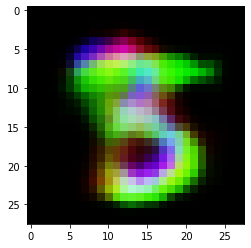

In [36]:
plt.imshow(pred.cpu().numpy().squeeze().transpose(1, 2, 0))